## Global Alignment Kernel

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

from tslearn.clustering import KernelKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from itertools import permutations, chain, combinations
import random as rnd

import matplotlib.pyplot as plt

import yfinance as yfin

Start by analyzing proof of positive defineteness of Alignment Kernel as proposed by authors in Cuturi, M., et al. (2007). *A Kernel for time sereis based on global alignment*, 2007 IEEE International Conference

In [ ]:

# Set random seed
rnd.seed(3)

# Prepare power set function to compute x_of_a

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# power_set = list(powerset(list(range(1,len(seq)+1))))[1:]

def integer_sequence(seq):
    init_seq = []
    n = 1
    for i in list(powerset(list(range(1,len(seq)+1))))[1:]:
        if len(i) == n:
            init_seq.append(list(permutations(range(1,len(i)+1))))
            n += 1
    int_seq = []
    for i in init_seq:
        for j in i:
            int_seq.append(j)
    return int_seq

# Test on Global Alignement Kernel
sspace = [0,1]
seq = rnd.choices(sspace, k = 3)
int_seq = integer_sequence(seq)
# int_seq = list(permutations(range(1,len(seq)+1)))

print(int_seq)
# print(seq)

def seq_of_a(seq = seq, int_seq = int_seq):
    soa = list()
    for x in int_seq:
        new_seq = []
        index = 0
        for i,j in enumerate(x):
            for y in range(j):
                new_seq.insert(index,seq[i])
                index += 1
        soa.append(new_seq) 
    return soa

print(seq_of_a())

def phi_s_of_x(seq_s, seq_x):
    count = 0
    int_seq_x = list(permutations(range(1,len(seq_x)+1)))
    for s in seq_of_a(seq_x, int_seq_x):
        print(s)
        if s == seq_s:
            count += 1
    return count

print(phi_s_of_x([0,0,0,1],[0,0,1]))
        


# new_seq = []
# index = 0
# for i,j in enumerate(int_seq[0]):
#     for y in range(j):
#         new_seq.insert(index,seq[i])
#         index += 1
# soa.append(new_sew)

#### Download test data

In [ ]:
# Download data sample
tickers = ["BTC-USD", "ETH-USD", "GOOG", "MSFT", "LINK-USD", "AAPL", "NFLX"]
start_date = "2020-01-01"
end_date = "2022-12-31"

yfin.pdr_override()

fin_data = []
for i in tickers:
    data = pdr.get_data_yahoo(i, start=start_date, end=end_date, interval="1wk")['Close']
    fin_data.append(np.array([[x] for x in data]))

fin_data = np.array(fin_data)

## UNCOMMENT TO DOWNLOAD FULL DATASET
# btc_data = pdr.get_data_yahoo(tickers[0],  start=start_date, end=end_date, interval = "1wk")
# eth_data = pdr.get_data_yahoo(tickers[1],  start=start_date, end=end_date, interval = "1wk")
# goog_data = pdr.get_data_yahoo(tickers[2],  start=start_date, end=end_date, interval = "1wk")
# msft_data = pdr.get_data_yahoo(tickers[3],  start=start_date, end=end_date, interval = "1wk")

# Normalize data
X = fin_data
X = TimeSeriesScalerMeanVariance().fit_transform(X)

# Save close data
btc_close = fin_data[0,:,:]
eth_close = fin_data[1,:,:]
goog_close = fin_data[2,:,:]
msft_close = fin_data[3,:,:]
nflx_close = fin_data[6,:,:]

In [ ]:
#Visualize time series
%matplotlib inline

btc_normalized_close = X[0,:,:]
eth_normalized_close = X[1,:,:]
goog_normalized_close = X[2,:,:]
msft_normalized_close = X[3,:,:]
nflx_normalized_close = X[6,:,:]

#X = np.array([btc_close.values,eth_close.values, msft_close.values, goog_close.values])


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0], freq='w'), eth_normalized_close, label = 'Ether')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), btc_normalized_close, label = 'Bitcoin')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), goog_normalized_close, label = 'Google')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), msft_normalized_close, label = 'Microsoft')
ax.plot(pd.date_range(start_date,periods=eth_normalized_close.shape[0],freq='w'), nflx_normalized_close, label = 'Netflix')
ax.legend()

In [ ]:
seed = 0
np.random.seed(seed)

# Align sample data structure to X_train


# x1 = np.array([[i] for i in btc_close])
# x2 = np.array([[i] for i in eth_close])
# x3 = np.array([[i] for i in goog_close])
# x4 = np.array([[i] for i in msft_close])
# X = np.array([x1,x2,x3,x4])
X = fin_data
X = TimeSeriesScalerMeanVariance().fit_transform(X)
print(fin_data.shape, X.shape)

# Check for alignment
# print(X_train.shape, X.shape)

sz = X.shape[1]

n_clusters = 3

gak_km = KernelKMeans(n_clusters=n_clusters,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=seed)
y_pred = gak_km.fit_predict(X)

plt.figure()
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [ ]:
def convert_data_gak(X = X):
    gak = []
    for i in range(X.shape[0]):
        gak.append([float(x) for x in X[i]])
    return np.array(gak)


In [65]:
from tslearn.metrics import gak, sigma_gak

gak_data = convert_data_gak()
sigma = sigma_gak(gak_data)
k_01 = gak(gak_data[4], gak_data[6], sigma=sigma)
print(k_01)

0.4459613498074039


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Init 1
4.567 --> 3.742 --> 3.742 --> 
Init 2
5.299 --> 5.299 --> 
Init 3
4.491 --> 4.008 --> 3.380 --> 3.380 --> 
Init 4
3.711 --> 3.369 --> 3.369 --> 
Init 5
3.860 --> 3.380 --> 3.380 --> 
Init 6
5.649 --> 5.369 --> 4.791 --> 3.742 --> 3.742 --> 
Init 7
4.336 --> 3.369 --> 3.369 --> 
Init 8
4.791 --> 3.742 --> 3.742 --> 
Init 9
3.993 --> 3.380 --> 3.380 --> 
Init 10
4.068 --> 3.369 --> 3.369 --> 
Init 11
5.091 --> 3.742 --> 3.742 --> 
Init 12
4.028 --> 3.369 --> 3.369 --> 
Init 13
4.491 --> 4.008 --> 3.380 --> 3.380 --> 
Init 14
5.106 --> 3.742 --> 3.742 --> 
Init 15
4.635 --> 3.369 --> 3.369 --> 
Init 16
3.614 --> 3.380 --> 3.380 --> 
Init 17
3.369 --> 3.369 --> 
Init 18
4.336 --> 3.369 --> 3.369 --> 
Init 19
4.180 --> 3.380 --> 3.380 --> 
Init 20
3.841 --> 3.369 --> 3.369 --> 
Init 1
4.012 --> 2.398 --> 2.191 --> 1.883 --> 1.883 --> 
Init 2
2.581 --> 2.493 --> 2.493 --> 
Init 3
3.544 --> 2.191 --> 1.883 --> 1.883 --> 
Init 4
3.150 --> 2.488 --> 2.488 --> 
Init 5
2.802 --> 1.883 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished


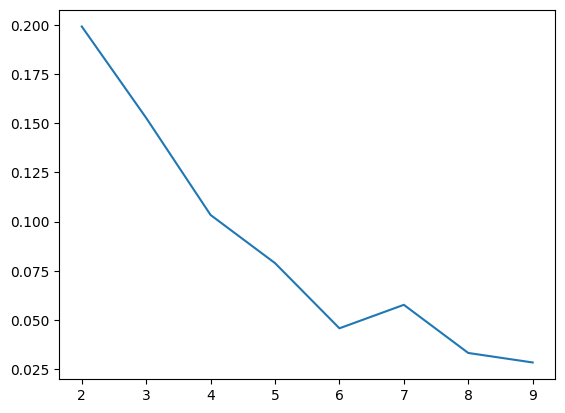

In [86]:
# Construct ELbow Method to finding optimal number of clusters in K-Means

#! the value of sigma needs to be aligned with the one used in the gaussian kernel of Global Alignment Kernel in K-means

final = []
for n_clusters in list(range(2,10)):
    gak_km = KernelKMeans(n_clusters=n_clusters,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=seed)
    y_pred = gak_km.fit_predict(X)
    gak_data = convert_data_gak(X)
    sigma = sigma_gak(gak_data)
    similar_indexes = []
    for i in list(range(n_clusters)):
        similar_indexes.append([v for v,n in enumerate(y_pred) if y_pred[v] == i])
    count = 1
    result = []
    for n in similar_indexes:
        gak_value = 0
        while count < len(n):
            for i in range(len(n)-1):
                for v in list(range(count,len(n))):
                    gak_value += gak(gak_data[i], gak_data[v], sigma=sigma)
                count += 1
        if sum(list(range(len(n)+1))) != 0:
            result.append(gak_value/sum(list(range(len(n)+1))))
        else:
            result.append(gak_value)
    final.append((n_clusters,sum(result)/n_clusters))
index = [i for i,v in final]
value = [v for i,v in final]
plt.plot(index, value)

    

In [82]:
l = [0,1,0,0,0,1,0,2] #y_pred
m = [] #similar indexes
for i in list(range(3)): #n_clusters
    m.append([v for v,n in enumerate(l) if l[v] == i])
print(m)

[[0, 2, 3, 4, 6], [1, 5], [7]]
